## [GitHub url]

### https://github.com/sujin1018/DL.git

## Load packages

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST train, test dataset 가져오기

In [5]:
# "": 현재 폴더에 MNIST 있음
mnist_train= dset.MNIST("", train= True, transform= transforms.ToTensor(),  # train 용으로 쓰겠다.
                       target_transform= None, download= True)
mnist_test= dset.MNIST("", train=False, transform= transforms.ToTensor(),  # test 용으로 쓰겠다.
                       target_transform= None, download= True)

## 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


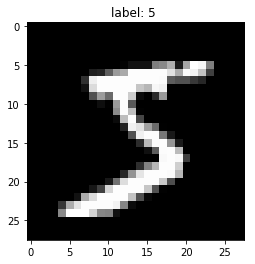

In [6]:
print "mnist_train 길이:", len(mnist_train)
print "mnist_test 길이:", len(mnist_test)

# 데이터 하나 형태
image, label= mnist_train.__getitem__(0)  # 0번째 데이터
print "image data 형태:", image.size()
print "label: ", label

# 그리기
img= image.numpy()  # image 타입을 numpy 로 변환 (1, 28, 28)
plt.title("label: %d " %label)
plt.imshow(img[0], cmap='gray')
plt.show()

## MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


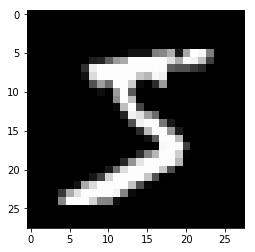

0


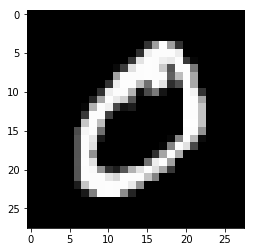

4


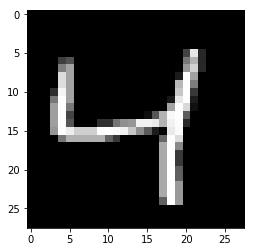

In [7]:
print(mnist_train[0][1])  # label
print(mnist_train[0][0].size())  # image

for i in range(3):
    img= mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0], cmap='gray')
    plt.show()

## convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


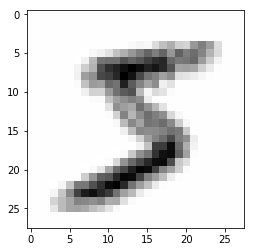

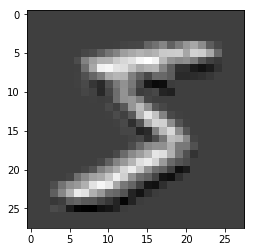

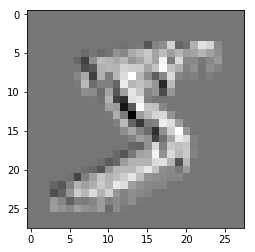

In [22]:
#mnist 의 첫 번재 이미지, 라벨 가져오기
image, label= mnist_train[0]
# view: tensor 의 사이즈 조절. -1: 해당 차원 확장시켜라
# [1, 28, 28] -> [1, 1, 28, 28]
image= image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print label

# convolutional filter 정의
conv_layer= nn.Conv2d(in_channels=1, out_channels= 3, kernel_size= 3, padding= 1)
# image에 filter 적용
output= conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap= 'gray')
    plt.show()

## CNN 만들기

### train, test data 가져오기

In [24]:
import numpy as np
import torch.optim as optim

batch_size= 16
learning_rate= 0.0002
num_epoch= 10 # 1000

In [25]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader= torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size= batch_size,
                                         shuffle= True, num_workers=2,
                                         drop_last= True)  # batch_szie 만큼 나눌 때 나머지는 버려라
test_loader= torch.utils.data.DataLoader((mnist_test), batch_size= batch_size,
                                         shuffle= False, num_workers=2,
                                         drop_last= True)

## CNN 클래스 만들기 (모델 만들기)

In [28]:
class CNN(nn.Module):  # nn.Module 상속받음
    def __init__(self):
        super(CNN, self).__init__()  # 28 x 28
        self.layer= nn.Sequential(
            nn.Conv2d(1, 16, 5, padding= 2),
            nn.ReLU(),
        
            nn.Conv2d(16, 32, 5, padding= 2),  # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # 28x28 -> 14x14
        
            nn.Conv2d(32, 64, 5, padding= 2),  # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)  # 14x14 -> 7x7
        )
        self.fc_layer= nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        out= self.layer(x)
        out= out.view(batch_size, -1)
        out= self.fc_layer(out)
        return out
    
model= CNN()  #.cuda()

In [30]:
# 파라미터 체크하기
for parameter in model.parameters():
    # print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [31]:
# loss function, optimizer 선언
loss_func= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)

## optimization

In [32]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader): # batch_size 만큼
        x= Variable(image)  # .cuda()
        y_= Variable(label)  # .cuda()
        
        optimizer.zero_grad()  # optimizer 안에서 이전 gradient 들을 초기화.
        output= model.forward(x)
        loss= loss_func(output, y_)
        loss.backward()  # gradient 계산
        optimizer.step()  # parameter 업데이트
        
        if j%50==0:
            print(loss, j, i)

(tensor(2.3158, grad_fn=<NllLossBackward>), 0, 0)
(tensor(1.6733, grad_fn=<NllLossBackward>), 50, 0)
(tensor(0.4851, grad_fn=<NllLossBackward>), 0, 1)
(tensor(0.5970, grad_fn=<NllLossBackward>), 50, 1)
(tensor(0.2513, grad_fn=<NllLossBackward>), 0, 2)
(tensor(0.4158, grad_fn=<NllLossBackward>), 50, 2)
(tensor(0.1970, grad_fn=<NllLossBackward>), 0, 3)
(tensor(0.0731, grad_fn=<NllLossBackward>), 50, 3)
(tensor(0.0378, grad_fn=<NllLossBackward>), 0, 4)
(tensor(0.1701, grad_fn=<NllLossBackward>), 50, 4)
(tensor(0.1856, grad_fn=<NllLossBackward>), 0, 5)
(tensor(0.1374, grad_fn=<NllLossBackward>), 50, 5)
(tensor(0.2839, grad_fn=<NllLossBackward>), 0, 6)
(tensor(0.0966, grad_fn=<NllLossBackward>), 50, 6)
(tensor(0.0174, grad_fn=<NllLossBackward>), 0, 7)
(tensor(0.0745, grad_fn=<NllLossBackward>), 50, 7)
(tensor(0.0115, grad_fn=<NllLossBackward>), 0, 8)
(tensor(0.0234, grad_fn=<NllLossBackward>), 50, 8)
(tensor(0.0945, grad_fn=<NllLossBackward>), 0, 9)
(tensor(0.0121, grad_fn=<NllLossBackward>

In [33]:
# 모델 저장시키기
torch.save(model, 'nets/mycnn_model_%d.pkl'%(num_epoch))

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
try:
    # 미리 학습시킨 네트워크의 파라미터 집합 [피클]이라 발음함.
    model=torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")

model restored


In [35]:
def ComputeAccr(dloader, imodel):
    correct= 0
    total= 0
    
    for j, [imgs, labels] in enumerate(dloader):  #batch_size 만큼
        img= Variable(imgs)  # .cuda() # x
        label= Variable(labels)  # y
        #label= Variable(labels).cuda()
        # .cuda(): GPU에 로드되기 위함. 만약 CPU로 설정되어 잇다면 에러남
        
        output= imodel.forward(img)  # forward prop.
        _, output_index= torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [36]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 95.0100021362
